## Fetch Rewards Coding Exercise - Data Analyst 

**Submitted by - Shefali Luley**

### First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

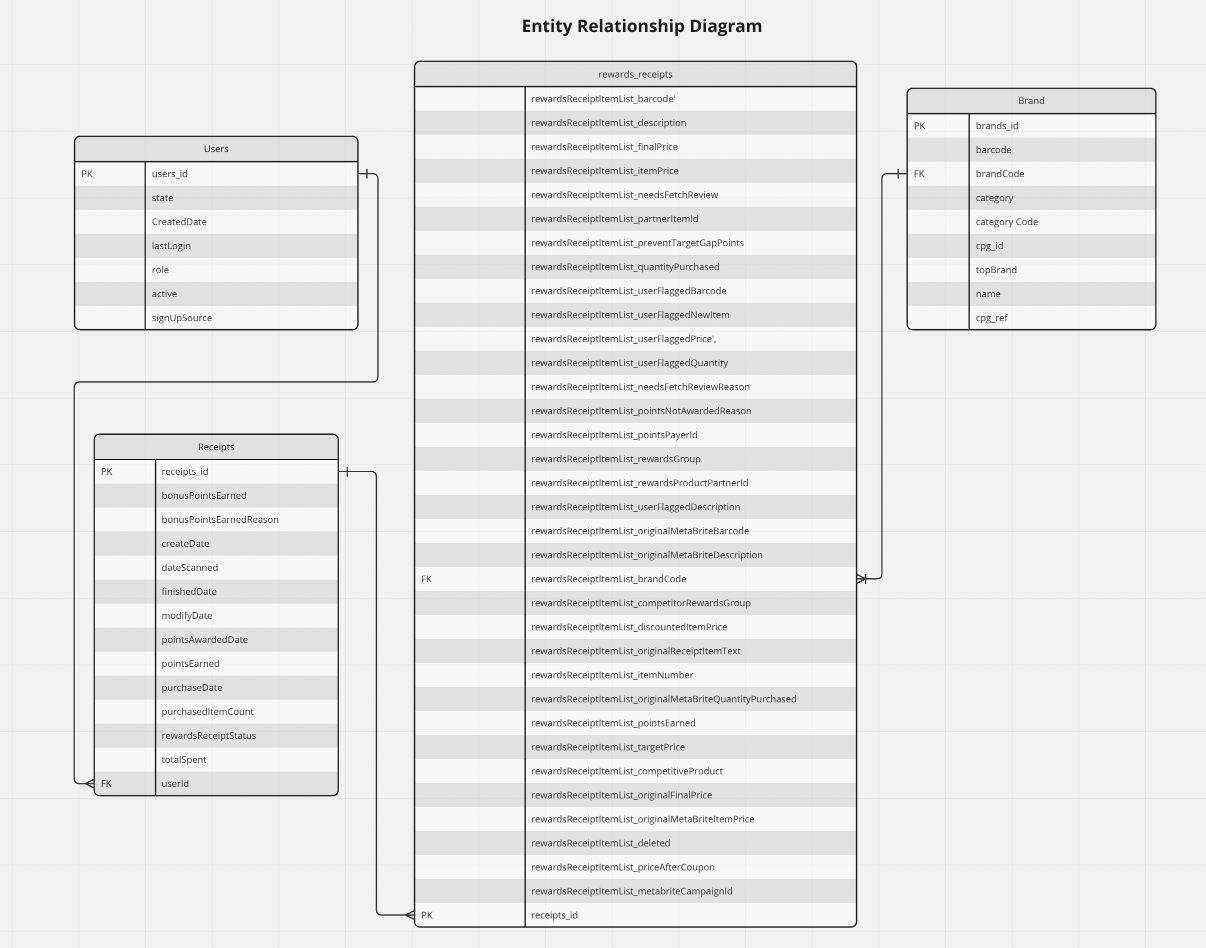

**Observations and assumption:**  
- The Users database and receipts table are observed to be connected via the UserId defined in the schema, facilitating data flow.
- A connection is noticed between the receipts table and the rewards_receipts table through the use of receipts_id, indicating a deliberate effort to enhance efficiency.
- It is observed that this connection between the tables significantly improves the performance of the receipts table by generating the rewards_receipts table.
- Furthermore, the rewards_receipts table is linked to the Brands table using brandcode, providing convenient access to brand-specific data since rewards_receipts.brandcode should be same as brands.brandcode.
- My observation also suggested that brandcode should be a foreign key since majority of data varies.

### Second: Write a query that directly answers a predetermined question from a business stakeholder

**1)What are the top 5 brands by receipts scanned for most recent month?**  

**Solution:**  

WITH cte0 as(  
    SELECT B.name, COUNT(*) AS receipts_count    
    FROM Brands B    
    JOIN rewards_receipts     
    ON B.brandCode = rewards_receipts.rewardsReceiptItemList_brandCode     
    JOIN receipts      
    ON rewards_receipts.receipts_id = receipts.receipts_id         
    WHERE DATE_FORMAT(receipts.date_scanned, '%m-%Y') = (Select Max(DATE_FORMAT(date_scanned, '%m-%Y')) FROM receipts) 
    GROUP BY B.name   
),  
cte1 as(  
SELECT name, receipts_count, DENSE_RANK() OVER(ORDER BY receipts_count DESC) AS rn FROM cte0 )  
SELECT name, receipts_count FROM cte1 WHERE rn <=5;  

  
  

- Here, I have joined  all the 3 tables and further filtered them to include only the receipts scanned in the recent month which is July 2023. 
- I have used DATE_FORMAT function to extract the month and the year form the date_scanned column. 
- Further, I have used the DENSE_RANK() function to assign ranks to each brand based on their receipt count. 

**2)How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?**


WITH this_month as(  
    SELECT B.name, COUNT(*) AS receipts_count    
    FROM Brands B    
    JOIN rewards_receipts    
    ON B.brandCode = rewards_receipts.rewardsReceiptItemList_brandCode     
    JOIN receipts      
    ON rewards_receipts.receipts_id = receipts.receipts_id         
    WHERE DATE_FORMAT(receipts.date_scanned, '%m-%Y') = (SELECT MAX(DATE_FORMAT(date_scanned, '%m-%Y')) FROM receipts) 
    GROUP BY B.name)    

this_month_rn AS(  
    SELECT name, receipts_count, DENSE_RANK() OVER(ORDER BY receipts_count DESC) AS rn FROM this_month ),   
this_month_top5 AS(  
    SELECT name, receipts_count FROM this_month_rn WHERE rn <=5),  
prev_month_brands(  
    SELECT B.name, COUNT(*) AS receipts_count    
    FROM Brands B    
    JOIN rewards_receipts    
    ON B.brandCode = rewards_receipts.rewardsReceiptItemList_brandCode      
    JOIN receipts      
    ON rewards_receipts.receipts_id = receipts.receipts_id         
    WHERE DATE_FORMAT(receipts.date_scanned, '%m-%Y') = (SELECT Date_format(DATE_SUB(MAX(date_scanned), INTERVAL 1   MONTH),'%m-%Y') FROM receipts)  
    GROUP BY B.name)    

prev_month_filter as(  
    SELECT name, receipts_count FROM prev_month_brands WHERE name IN (SELECT name FROM this_month_top5)  
    UNION  
    SELECT name, 0 AS receipts_count FROM this_month_top5 WHERE name NOT IN (SELECT name FROM prev_month_brands))  
    
SELECT tm.name,  
tm.receipts_count AS this_month_count,  
pm.receipts_count AS previous_month_count   
FROM this_month_top5 tm, prev_month_filter pm   
WHERE pm.name = tm.name  
ORDER BY 1;    



- Here, I have created a temporary table called "this_month" which selects the name of the brand & counts the number of receipts for each brand.
- Then, I have joined the 3 tables based on specific conditions, filtering the receipts based on the current month.
- Next, I have created a temporaru table "this_month_rn" which adds a rank column to the previous table based on the receipts count, ordering them in descending order. 
- The rank here is generated using the DENSE_RANK() function.
- Now,again a new table '"this_month_top5" is derived from "this_month_rn" by selecting only the top 5 brands based on the rank.
- Another temporary table is created "prev_month_brands," which performs a similar analysis but for the previous month. It also counts the receipts for each brand from the previous month.
- Then next, "prev_month_filter" table is derived from "prev_month_brands" by filtering the brands to only include those that appear in the "this_month_top5" table. 
- It also includes brands with a receipts count of 0 that are not present in the "prev_month_brands" table.
- Lastly, the main query selects the brand name, the receipts count for the current month, and the receipts count for the previous month from the "this_month_top5" and "prev_month_filter" tables. 
- It joins these tables based on the brand name and orders the result by the brand name.



**3)When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?**  

**Solution:**   
SELECT rewardsReceiptStatus,  
AVG(totalSpent) AS average_spend  
FROM receipts  
WHERE rewardsReceiptStatus = ‘Finished’ OR rewardsReceiptStatus = 'Rejected'  
GROUP BY rewardsReceiptStatus  
ORDER BY average_spend DESC;  


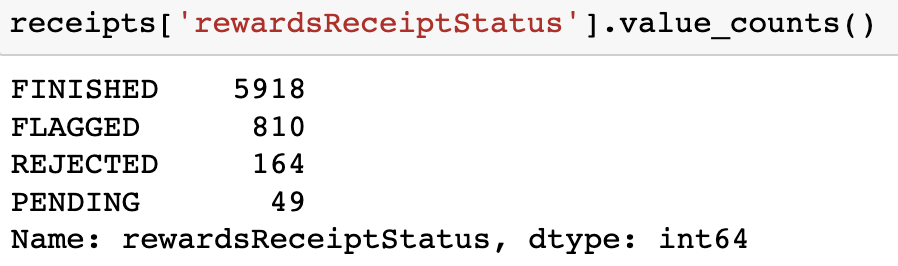

- During the process of working on SQL queries to identify rewardsReceiptStatus as "Accepted" or "Rejected," I conducted value counts to gain insights into the distribution and frequency of values within the dataset. 
- However, it was noticed that there was no mention of the status "Accepted" anywhere, while the status "Finished" was present. This observation suggests a potential data quality issue within the dataset. 
- To minimize this issue , I have included it in the above query, assuming that "Finished" is equivalent to "Accepted."


**4)When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?**

SELECT rewardsReceiptStatus,  
SUM(purchasedItemCount) AS totalItemsPurchased 
FROM receipts  
WHERE rewardsReceiptStatus = ‘Finished’ OR rewardsReceiptStatus = 'Rejected'  
GROUP BY rewardsReceiptStatus  
ORDER BY totalItemsPurchased DESC;    

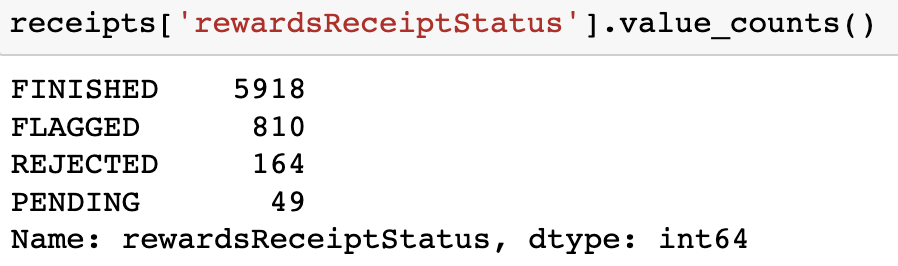

- During the process of working on SQL queries to identify rewardsReceiptStatus as "Accepted" or "Rejected," I conducted value counts to gain insights into the distribution and frequency of values within the dataset. 
- However, it was noticed that there was no mention of the status "Accepted" anywhere, while the status "Finished" was present. This observation suggests a potential data quality issue within the dataset. 
- To minimize this issue , I have included it in the above query, assuming that "Finished" is equivalent to "Accepted."


**5)Which brand has the most spend among users who were created within the past 6 months?**  

**Solutions:**   

SELECT B.name, SUM(receipts.totalSpent) AS most_spend    
FROM(SELECT user.users_id , DENSE_RANK() OVER(ORDER BY SUM(receipts.totalSpent)DESC) AS rn    
     FROM users    
     JOIN receipts ON U1            
     ON receipts.users_id = users.users_id        
     JOIN rewards_receipts     
     ON rewards_receipts.receipts_id = receipts.receipts_id          
     JOIN brands B    
     ON B.brandCode = rewards_receipts.rewardsReceiptItemList_brandCode    
     WHERE users.created_date BETWEEN '2023-01-01' AND '2023-6-30'    
     GROUP BY users.users_id  
) AS U1   
WHERE U1.rn = 1  
ORDER BY most_spend DESC  
LIMIT 1;  


- Firstly, , I have calculated the sum of totalspent for each brand among these users in the past 6 months time frame.
- Next, The inner subquery calculates the rank of each user based on their total spending along with joining of the 4 tables, while the outer select with rank = 1 and further the result is printed in descending order.  
- Lastly, the limit is set to 1 to retrieve the top most brand.  


**6)Which brand has the most transactions among users who were created within the past 6 months?**

**Solution:**  

SELECT B.name, COUNT(*) AS transcation_count    
FROM(SELECT user.users_id , DENSE_RANK() OVER(ORDER BY COUNT(*) DESC) AS rn      
     FROM users      
     JOIN receipts ON U1            
     ON receipts.users_id = users.users_id        
     JOIN rewards_receipts       
     ON rewards_receipts.receipts_id = receipts.receipts_id          
     JOIN brands B    
     ON B.brandCode = rewards_receipts.rewardsReceiptItemList_brandCode    
     WHERE users.created_date BETWEEN '2023-01-01' AND '2023-6-30'    
     GROUP BY users.users_id  
) AS U1   
WHERE U1.rn = 1  
ORDER BY transcation_count DESC  
LIMIT 1;  


- Here, I have selected the transcation count from brands for the users with the highest number of transactions during the  past 6 months. 
- Next, The inner subquery calculates the rank of each user based on the count of their transcation along with joining of the 4 tables, while the outer select with rank = 1 and further the result is printed in descending order.  
- Lastly, the limit is set to 1 to retrieve the top most brand.  

### Third: Evaluate Data Quality Issues in the Data Provided


In [1]:
#loading all the important libraries

import warnings 
warnings.filterwarnings('ignore')

# import basic packages

import os
import numpy as np
import pandas as pd
import missingno as msno
import json
import re
import ujson as json
import json
import csv
import sqlite3 as db

#import visualization packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline


#### Defining a json function

In [2]:
def read_nested_json(file_name):
    # Read the JSON file line by line and append the dictionaries to a list
    data = []
    with open(file_name, "r") as file:
        for line in file:
            record = json.loads(line)
            data.append(record)

    if file_name=='receipts.json':
    # Normalize the specified columns using json_normalize
        df = pd.json_normalize(data)
        meta_1=[cols for cols in df.columns if cols not in ['rewardsReceiptItemList']]
        df=pd.json_normalize(df.to_dict('records'), 'rewardsReceiptItemList', meta_1,record_prefix='rewardsReceiptItemList_')

    else:
        df = pd.json_normalize(data)
    
    return df

#### Approach:

- After importing the correct libraries, here I have defined a function called "read_nested_json". 
- This function reads the UJSON , in line by line manner and appends each dictionary to list called data.
- Next, it observations suggest that "receipts", consists of nested json, so normalize function is used from pandas library to normalize the data.
- Within the normalization process, it selects specific columns to be retained as metadata, excluding the 'rewardsReceiptItemList' column.

In [3]:
#Normalizing JSON files for receipts, brands, and users and storing them in respective dataframe
receipts= read_nested_json('receipts.json')
brands= read_nested_json('brands.json')
users= read_nested_json('users.json')

#### Printing columns of each dataset

In [4]:
receipts.columns

Index(['rewardsReceiptItemList_barcode', 'rewardsReceiptItemList_description',
       'rewardsReceiptItemList_finalPrice', 'rewardsReceiptItemList_itemPrice',
       'rewardsReceiptItemList_needsFetchReview',
       'rewardsReceiptItemList_partnerItemId',
       'rewardsReceiptItemList_preventTargetGapPoints',
       'rewardsReceiptItemList_quantityPurchased',
       'rewardsReceiptItemList_userFlaggedBarcode',
       'rewardsReceiptItemList_userFlaggedNewItem',
       'rewardsReceiptItemList_userFlaggedPrice',
       'rewardsReceiptItemList_userFlaggedQuantity',
       'rewardsReceiptItemList_needsFetchReviewReason',
       'rewardsReceiptItemList_pointsNotAwardedReason',
       'rewardsReceiptItemList_pointsPayerId',
       'rewardsReceiptItemList_rewardsGroup',
       'rewardsReceiptItemList_rewardsProductPartnerId',
       'rewardsReceiptItemList_userFlaggedDescription',
       'rewardsReceiptItemList_originalMetaBriteBarcode',
       'rewardsReceiptItemList_originalMetaBriteDescri

In [5]:
brands.columns

Index(['barcode', 'category', 'categoryCode', 'name', 'topBrand', '_id.$oid',
       'cpg.$id.$oid', 'cpg.$ref', 'brandCode'],
      dtype='object')

In [6]:
users.columns

Index(['active', 'role', 'signUpSource', 'state', '_id.$oid',
       'createdDate.$date', 'lastLogin.$date'],
      dtype='object')

### Data Cleaning  in "Receipts"

In [7]:
receipts.columns

Index(['rewardsReceiptItemList_barcode', 'rewardsReceiptItemList_description',
       'rewardsReceiptItemList_finalPrice', 'rewardsReceiptItemList_itemPrice',
       'rewardsReceiptItemList_needsFetchReview',
       'rewardsReceiptItemList_partnerItemId',
       'rewardsReceiptItemList_preventTargetGapPoints',
       'rewardsReceiptItemList_quantityPurchased',
       'rewardsReceiptItemList_userFlaggedBarcode',
       'rewardsReceiptItemList_userFlaggedNewItem',
       'rewardsReceiptItemList_userFlaggedPrice',
       'rewardsReceiptItemList_userFlaggedQuantity',
       'rewardsReceiptItemList_needsFetchReviewReason',
       'rewardsReceiptItemList_pointsNotAwardedReason',
       'rewardsReceiptItemList_pointsPayerId',
       'rewardsReceiptItemList_rewardsGroup',
       'rewardsReceiptItemList_rewardsProductPartnerId',
       'rewardsReceiptItemList_userFlaggedDescription',
       'rewardsReceiptItemList_originalMetaBriteBarcode',
       'rewardsReceiptItemList_originalMetaBriteDescri

#### To avoid ambiguity renaming the column names.

In [8]:
receipts.rename(columns = {'_id.$oid': 'receipts_id', 
                           'createDate.$date': 'create_date',
                           'dateScanned.$date': 'date_scanned',
                           'finishedDate.$date': 'finished_date',
                           'modifyDate.$date' : 'modify_date',
                           'pointsAwardedDate.$date': 'points_Awarded_Date', 
                           'purchaseDate.$date': 'purchase_Date'
                          },inplace = True
                          )

In [9]:
receipts.head()

,rewardsReceiptItemList_barcode,rewardsReceiptItemList_description,rewardsReceiptItemList_finalPrice,rewardsReceiptItemList_itemPrice,rewardsReceiptItemList_needsFetchReview,rewardsReceiptItemList_partnerItemId,rewardsReceiptItemList_preventTargetGapPoints,rewardsReceiptItemList_quantityPurchased,rewardsReceiptItemList_userFlaggedBarcode,rewardsReceiptItemList_userFlaggedNewItem,...,rewardsReceiptStatus,totalSpent,userId,receipts_id,create_date,date_scanned,finished_date,modify_date,points_Awarded_Date,purchase_Date
0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,...,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6,5ff1e1eb0a720f0523000575,1609687531000,1609687531000,1609687531000.0,1609687536000,1609687531000.0,1609632000000.0
1,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,...,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,1609687483000,1609687483000,1609687483000.0,1609687488000,1609687483000.0,1609601083000.0
2,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,...,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,1609687483000,1609687483000,1609687483000.0,1609687488000,1609687483000.0,1609601083000.0
3,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,...,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b,5ff1e1f10a720f052300057a,1609687537000,1609687537000,NaN,1609687542000,NaN,1609632000000.0
4,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,...,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6,5ff1e1ee0a7214ada100056f,1609687534000,1609687534000,1609687534000.0,1609687539000,1609687534000.0,1609632000000.0


#### Data Quality Issue  :  "Date" columns are not in datetime format

**Converting date columns in datetime format:**  

It can be observed that their is inconsistency in the "date" columns. Here, we are fixing the data quality issue:

The data quality issue observed here in receipts dataset is that the dataset contains 6 columns ending in "date", but the values in this column are not in the expected datetime format. Instead they appear to be in various formats. To ensure the data consistency and proper analysis, the date column is converted to a standardized datetime format.


In [10]:
#converting into datetime format
receipts['create_date'] = pd.to_datetime(receipts['create_date'])
receipts['date_scanned'] = pd.to_datetime(receipts['date_scanned'])
receipts['finished_date'] = pd.to_datetime(receipts['finished_date'])
receipts['modify_date'] = pd.to_datetime(receipts['modify_date'])
receipts['points_Awarded_Date'] = pd.to_datetime(receipts['points_Awarded_Date'])
receipts['purchase_Date'] = pd.to_datetime(receipts['purchase_Date'])

In [11]:
receipts.head(2)

,rewardsReceiptItemList_barcode,rewardsReceiptItemList_description,rewardsReceiptItemList_finalPrice,rewardsReceiptItemList_itemPrice,rewardsReceiptItemList_needsFetchReview,rewardsReceiptItemList_partnerItemId,rewardsReceiptItemList_preventTargetGapPoints,rewardsReceiptItemList_quantityPurchased,rewardsReceiptItemList_userFlaggedBarcode,rewardsReceiptItemList_userFlaggedNewItem,...,rewardsReceiptStatus,totalSpent,userId,receipts_id,create_date,date_scanned,finished_date,modify_date,points_Awarded_Date,purchase_Date
0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,...,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6,5ff1e1eb0a720f0523000575,1970-01-01 00:26:49.687531,1970-01-01 00:26:49.687531,1970-01-01 00:26:49.687531,1970-01-01 00:26:49.687536,1970-01-01 00:26:49.687531,1970-01-01 00:26:49.632000
1,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,...,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.687488,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.601083


#### Data Quality Issue : Inconsistent Data


During the process of working on SQL queries to identify rewardsReceiptStatus as "Accepted" or "Rejected," I conducted value counts to gain insights into the distribution and frequency of values within the dataset. However, it was noticed that there was no mention of the status "Accepted" anywhere, while the status "Finished" was present. This observation suggests a potential data quality issue within the dataset. 


In [12]:
receipts['rewardsReceiptStatus'].value_counts()

FINISHED    5918
FLAGGED      810
REJECTED     164
PENDING       49
Name: rewardsReceiptStatus, dtype: int64

### Creation of rewards_receipts dataframe and data cleaning

#### Creating a seperate dataframe consisting of all the "rewardsReceiptItemList" columns to increase efficiency

In [13]:
rewards_receipts = receipts[['receipts_id','rewardsReceiptItemList_barcode', 'rewardsReceiptItemList_description',
       'rewardsReceiptItemList_finalPrice', 'rewardsReceiptItemList_itemPrice',
       'rewardsReceiptItemList_needsFetchReview',
       'rewardsReceiptItemList_partnerItemId',
       'rewardsReceiptItemList_preventTargetGapPoints',
       'rewardsReceiptItemList_quantityPurchased',
       'rewardsReceiptItemList_userFlaggedBarcode',
       'rewardsReceiptItemList_userFlaggedNewItem',
       'rewardsReceiptItemList_userFlaggedPrice',
       'rewardsReceiptItemList_userFlaggedQuantity',
       'rewardsReceiptItemList_needsFetchReviewReason',
       'rewardsReceiptItemList_pointsNotAwardedReason',
       'rewardsReceiptItemList_pointsPayerId',
       'rewardsReceiptItemList_rewardsGroup',
       'rewardsReceiptItemList_rewardsProductPartnerId',
       'rewardsReceiptItemList_userFlaggedDescription',
       'rewardsReceiptItemList_originalMetaBriteBarcode',
       'rewardsReceiptItemList_originalMetaBriteDescription',
       'rewardsReceiptItemList_brandCode',
       'rewardsReceiptItemList_competitorRewardsGroup',
       'rewardsReceiptItemList_discountedItemPrice',
       'rewardsReceiptItemList_originalReceiptItemText',
       'rewardsReceiptItemList_itemNumber',
       'rewardsReceiptItemList_originalMetaBriteQuantityPurchased',
       'rewardsReceiptItemList_pointsEarned',
       'rewardsReceiptItemList_targetPrice',
       'rewardsReceiptItemList_competitiveProduct',
       'rewardsReceiptItemList_originalFinalPrice',
       'rewardsReceiptItemList_originalMetaBriteItemPrice',
       'rewardsReceiptItemList_deleted',
       'rewardsReceiptItemList_priceAfterCoupon',
       'rewardsReceiptItemList_metabriteCampaignId']]

In [14]:
rewards_receipts.head()

,receipts_id,rewardsReceiptItemList_barcode,rewardsReceiptItemList_description,rewardsReceiptItemList_finalPrice,rewardsReceiptItemList_itemPrice,rewardsReceiptItemList_needsFetchReview,rewardsReceiptItemList_partnerItemId,rewardsReceiptItemList_preventTargetGapPoints,rewardsReceiptItemList_quantityPurchased,rewardsReceiptItemList_userFlaggedBarcode,...,rewardsReceiptItemList_itemNumber,rewardsReceiptItemList_originalMetaBriteQuantityPurchased,rewardsReceiptItemList_pointsEarned,rewardsReceiptItemList_targetPrice,rewardsReceiptItemList_competitiveProduct,rewardsReceiptItemList_originalFinalPrice,rewardsReceiptItemList_originalMetaBriteItemPrice,rewardsReceiptItemList_deleted,rewardsReceiptItemList_priceAfterCoupon,rewardsReceiptItemList_metabriteCampaignId
0,5ff1e1eb0a720f0523000575,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#checking null values present in the dataset
rewards_receipts.isnull().sum()

receipts_id                                                     0
rewardsReceiptItemList_barcode                               3851
rewardsReceiptItemList_description                            381
rewardsReceiptItemList_finalPrice                             174
rewardsReceiptItemList_itemPrice                              174
rewardsReceiptItemList_needsFetchReview                      6128
rewardsReceiptItemList_partnerItemId                            0
rewardsReceiptItemList_preventTargetGapPoints                6583
rewardsReceiptItemList_quantityPurchased                      174
rewardsReceiptItemList_userFlaggedBarcode                    6604
rewardsReceiptItemList_userFlaggedNewItem                    6618
rewardsReceiptItemList_userFlaggedPrice                      6642
rewardsReceiptItemList_userFlaggedQuantity                   6642
rewardsReceiptItemList_needsFetchReviewReason                6722
rewardsReceiptItemList_pointsNotAwardedReason                6601
rewardsRec

#### Data Quality Issue  : Missing Values
- The rewards_receipts presents a significant data quality issue, as numerous columns contain a high number of missing values. 
- However, dropping or imputing these values is not a viable option since each column holds unique data. 
- This poses a considerable challenge in ensuring the completeness and accuracy of the dataset. 
- Addressing this issue requires innovative approaches that go beyond traditional methods of data cleaning and manipulation.
- It highlights the complexity and uniqueness of the dataset, urging us to explore alternative strategies to mitigate the impact of missing values while preserving the integrity of the data.

### Removing the reward_receipts data from receipts

#### Dropping the columns from the "rewardsReceiptItemList" dataframe present in "receipt" dataset.

In [16]:
drop_columns = ['rewardsReceiptItemList_barcode', 'rewardsReceiptItemList_description',
       'rewardsReceiptItemList_finalPrice', 'rewardsReceiptItemList_itemPrice',
       'rewardsReceiptItemList_needsFetchReview',
       'rewardsReceiptItemList_partnerItemId',
       'rewardsReceiptItemList_preventTargetGapPoints',
       'rewardsReceiptItemList_quantityPurchased',
       'rewardsReceiptItemList_userFlaggedBarcode',
       'rewardsReceiptItemList_userFlaggedNewItem',
       'rewardsReceiptItemList_userFlaggedPrice',
       'rewardsReceiptItemList_userFlaggedQuantity',
       'rewardsReceiptItemList_needsFetchReviewReason',
       'rewardsReceiptItemList_pointsNotAwardedReason',
       'rewardsReceiptItemList_pointsPayerId',
       'rewardsReceiptItemList_rewardsGroup',
       'rewardsReceiptItemList_rewardsProductPartnerId',
       'rewardsReceiptItemList_userFlaggedDescription',
       'rewardsReceiptItemList_originalMetaBriteBarcode',
       'rewardsReceiptItemList_originalMetaBriteDescription',
       'rewardsReceiptItemList_brandCode',
       'rewardsReceiptItemList_competitorRewardsGroup',
       'rewardsReceiptItemList_discountedItemPrice',
       'rewardsReceiptItemList_originalReceiptItemText',
       'rewardsReceiptItemList_itemNumber',
       'rewardsReceiptItemList_originalMetaBriteQuantityPurchased',
       'rewardsReceiptItemList_pointsEarned',
       'rewardsReceiptItemList_targetPrice',
       'rewardsReceiptItemList_competitiveProduct',
       'rewardsReceiptItemList_originalFinalPrice',
       'rewardsReceiptItemList_originalMetaBriteItemPrice',
       'rewardsReceiptItemList_deleted',
       'rewardsReceiptItemList_priceAfterCoupon',
       'rewardsReceiptItemList_metabriteCampaignId']
receipts = receipts.drop(columns = drop_columns)

In [17]:
receipts.columns

Index(['bonusPointsEarned', 'bonusPointsEarnedReason', 'pointsEarned',
       'purchasedItemCount', 'rewardsReceiptStatus', 'totalSpent', 'userId',
       'receipts_id', 'create_date', 'date_scanned', 'finished_date',
       'modify_date', 'points_Awarded_Date', 'purchase_Date'],
      dtype='object')

**Identifying and dropping duplicate data**

- After segregating the rewards_receipts data into a separate table, I am currently examining the receipts dataset for any duplicate entries and intend to remove them accordingly. 
- This step is crucial to ensure data integrity and eliminate any redundancy that may affect the accuracy of subsequent analyses or operations.

In [18]:
receipts[receipts.duplicated()]

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,receipts_id,create_date,date_scanned,finished_date,modify_date,points_Awarded_Date,purchase_Date
2,150.0,"Receipt number 5 completed, bonus point schedu...",150.0,2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.687488,1970-01-01 00:26:49.687483,1970-01-01 00:26:49.601083
6,5.0,All-receipts receipt bonus,5.0,2.0,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052,5ff1e1d20a7214ada1000561,1970-01-01 00:26:49.687506,1970-01-01 00:26:49.687506,1970-01-01 00:26:49.687511,1970-01-01 00:26:49.687511,1970-01-01 00:26:49.687506,1970-01-01 00:26:49.601106
15,150.0,"Receipt number 5 completed, bonus point schedu...",8850.0,10.0,FLAGGED,290.00,5ff1e194b6a9d73a3a9f1052,5ff1e1b60a7214ada100055c,1970-01-01 00:26:49.687478,1970-01-01 00:26:49.687478,NaT,1970-01-01 00:26:49.687478,NaT,1970-01-01 00:26:52.365878
16,150.0,"Receipt number 5 completed, bonus point schedu...",8850.0,10.0,FLAGGED,290.00,5ff1e194b6a9d73a3a9f1052,5ff1e1b60a7214ada100055c,1970-01-01 00:26:49.687478,1970-01-01 00:26:49.687478,NaT,1970-01-01 00:26:49.687478,NaT,1970-01-01 00:26:52.365878
17,150.0,"Receipt number 5 completed, bonus point schedu...",8850.0,10.0,FLAGGED,290.00,5ff1e194b6a9d73a3a9f1052,5ff1e1b60a7214ada100055c,1970-01-01 00:26:49.687478,1970-01-01 00:26:49.687478,NaT,1970-01-01 00:26:49.687478,NaT,1970-01-01 00:26:52.365878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33,603c7c6c0a7217c72c0003b3,1970-01-01 00:26:54.576748,1970-01-01 00:26:54.576748,NaT,1970-01-01 00:26:54.576749,NaT,1970-01-01 00:26:37.622400
6934,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33,603c3d240a720fde10000373,1970-01-01 00:26:54.560548,1970-01-01 00:26:54.560548,NaT,1970-01-01 00:26:54.560549,NaT,1970-01-01 00:26:37.622400
6936,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33,603cc2bc0a720fde100003e9,1970-01-01 00:26:54.594748,1970-01-01 00:26:54.594748,NaT,1970-01-01 00:26:54.594749,NaT,1970-01-01 00:26:37.622400
6938,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33,603cc0630a720fde100003e6,1970-01-01 00:26:54.594147,1970-01-01 00:26:54.594147,NaT,1970-01-01 00:26:54.594148,NaT,1970-01-01 00:26:37.622400


In [19]:
receipts.drop_duplicates(inplace = True)

In [20]:
receipts.isnull().sum()

bonusPointsEarned          137
bonusPointsEarnedReason    137
pointsEarned                72
purchasedItemCount          49
rewardsReceiptStatus         0
totalSpent                   0
userId                       0
receipts_id                  0
create_date                  0
date_scanned                 0
finished_date              114
modify_date                  0
points_Awarded_Date        144
purchase_Date               11
dtype: int64

#### Data Quality Issue  : Missing data

- The data reveals a significant data quality issue, wherein each column contains a substantial number of missing values.
- Notably, the columns "bonusPointsEarned" and "bonusPointsEarnedReason" exhibit 963 missing values, while "pointsEarned" and "purchasedItemCount" have 690 and 49 missing values, respectively. 
- Observations suggest that "rewardsReceiptStatus," "totalSpent," "userId," "receipts_id," "create_date," and "date_scanned" also exhibit no null values.

- This multitude of missing values across various columns poses one of the most significant data quality challenges in this dataset. 
- Given the unique nature of the data within each column, dropping or imputing the missing values is not a feasible option.

### Data Cleaning in Users

In [21]:
users.columns

Index(['active', 'role', 'signUpSource', 'state', '_id.$oid',
       'createdDate.$date', 'lastLogin.$date'],
      dtype='object')

#### To avoid ambiguity renaming the column names.

In [22]:
users.rename(columns = {'_id.$oid': 'users_id', 
                           'createdDate.$date': 'created_date',
                           'lastLogin.$date': 'last_Login'
                          },inplace = True
                          )

In [23]:
users.head(10)

,active,role,signUpSource,state,users_id,created_date,last_Login
0,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
1,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
2,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
3,True,consumer,Email,WI,5ff1e1eacfcf6c399c274ae6,1609687530554,1.609688e+12
4,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
5,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
6,True,consumer,Email,WI,5ff1e1e8cfcf6c399c274ad9,1609687528354,1.609688e+12
7,True,consumer,Email,WI,5ff1e1b7cfcf6c399c274a5a,1609687479626,1.609687e+12
8,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
9,True,consumer,Email,WI,5ff1e1f1cfcf6c399c274b0b,1609687537564,1.609688e+12


In [24]:
users.columns

Index(['active', 'role', 'signUpSource', 'state', 'users_id', 'created_date',
       'last_Login'],
      dtype='object')

In [25]:
users.isnull().sum()

active           0
role             0
signUpSource    48
state           56
users_id         0
created_date     0
last_Login      62
dtype: int64

#### Data Quality Issue : Missing values

- This dataset stands out from the rest as it contains minimal missing values across most columns. 
- The column "active" and "role" show no missing values, while "signUpSource" has 48 missing values and "state" has 56 missing values. 
- Similarly, "users_id" and "created_date" exhibit no missing values. However, "last_Login" column has 62 missing values.
- Comparatively, this particular dataset demonstrates a relatively lower occurrence of missing values.

### Data Cleaning in Brands

In [26]:
brands.columns

Index(['barcode', 'category', 'categoryCode', 'name', 'topBrand', '_id.$oid',
       'cpg.$id.$oid', 'cpg.$ref', 'brandCode'],
      dtype='object')

#### To avoid ambiguity renaming the column names.

In [27]:
brands.rename(columns = { '_id.$oid': 'brands_id', 
                           'cpg.$id.$oid': 'cpg_id',
                           'cpg.$ref': 'cpg_ref'}, inplace = True)

In [28]:
brands.head(2)

,barcode,category,categoryCode,name,topBrand,brands_id,cpg_id,cpg_ref,brandCode
0,511111019862,Baking,BAKING,test brand @1612366101024,False,601ac115be37ce2ead437551,601ac114be37ce2ead437550,Cogs,NaN
1,511111519928,Beverages,BEVERAGES,Starbucks,False,601c5460be37ce2ead43755f,5332f5fbe4b03c9a25efd0ba,Cogs,STARBUCKS


In [29]:
brands.columns

Index(['barcode', 'category', 'categoryCode', 'name', 'topBrand', 'brands_id',
       'cpg_id', 'cpg_ref', 'brandCode'],
      dtype='object')

In [30]:
brands.isnull().sum()

barcode           0
category        155
categoryCode    650
name              0
topBrand        612
brands_id         0
cpg_id            0
cpg_ref           0
brandCode       234
dtype: int64

#### Data Quality Issue : Missing values and missing column data

- This dataset contains minimal missing values, it also contains row with missing column data such as " Brand Code" is missing in most of the rows as a whole column in general.
- The column "barcode" and "name" show no missing values, while "category" has 155 missing values and "Categorycode" has 650 missing values. 
- Similarly, "brands_id", "cpg_ref" and "cpg_id" exhibit no missing values. However, "last_Login" column has 62 missing values.
- This dataset also demonstrates a relatively lower occurrence of missing values.

In [31]:
brands.to_csv('brands.csv', index= False)

### Insights and Exploratory Data Analysis

#### Identfying unique columns and insights

In [32]:
brands['category'].unique()

array(['Baking', 'Beverages', 'Candy & Sweets', 'Condiments & Sauces',
       'Canned Goods & Soups', nan, 'Magazines', 'Breakfast & Cereal',
       'Beer Wine Spirits', 'Health & Wellness', 'Beauty', 'Baby',
       'Frozen', 'Grocery', 'Snacks', 'Household', 'Personal Care',
       'Dairy', 'Cleaning & Home Improvement', 'Deli',
       'Beauty & Personal Care', 'Bread & Bakery', 'Outdoor',
       'Dairy & Refrigerated'], dtype=object)

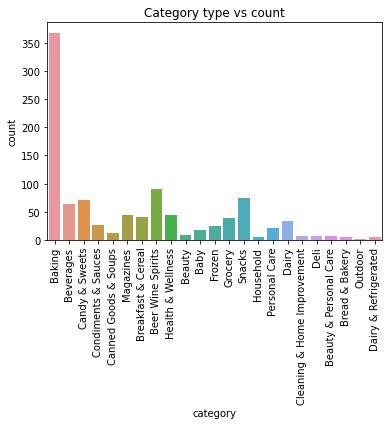

In [33]:
#print(brands['category'].value_counts())
sns.countplot(brands['category'])
plt.title("Category type vs count")
plt.xticks(rotation=90)
plt.show()

**Observations :**  
- The category "Baking" has the highest count with 369 occurrences.
- "Beer Wine Spirits" is the second most common category with 90 occurrences.
- Beauty," "Cleaning & Home Improvement," "Deli," "Beauty & Personal Care," "Household," "Bread & Bakery," and "Dairy & Refrigerated" have relatively fewer occurrences, with counts ranging from 9 to 5.
- Finally, the category "Outdoor" has the lowest count, with only 1 occurrence.


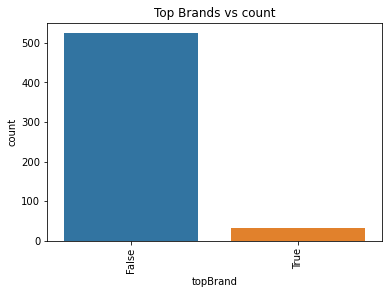

In [34]:
#print(brands['topBrand'].value_counts())
sns.countplot(brands['topBrand'])
plt.title("Top Brands vs count")
plt.xticks(rotation=90)
plt.show()

**Obervations:**  
- The category "False" represents the majority of brands, with a count of 524.
- The category "True" represents a smaller subset of brands, with a count of 31.
- It appears that the top brands are predominantly classified under the "False" category.


### Fourth: Communicate with Stakeholders

**(For this part. I am assuming that I am writing an email to Sandy,my fictional business leader, informing about my analysis and issues of data.)**


Subject: Overview regarding the Fetch Rewards data

Dear Sandy,

I hope this email finds you well. I wanted to provide you with an overview of my analysis on the Fetch Rewards data and discuss the data issues I encountered.To begin with, my analysis focused on four main parameters. First, I aimed to identify the entity relationship between the three tables: Receipts, Users, and Brand. Second, I developed SQL queries to address questions from the business stakeholders. Third, I evaluated the data quality issues present in the data. Lastly, I prepared a brief overview of my findings.

To establish the entity relationship, I began by examining the given JSON data and proceeded with the process of structuring it. This involved parsing the JSON format and organizing the data into a more organized and coherent structure. By doing so, I aimed to identify the relationships between different entities within the data and understand how they were interconnected. 

To improve efficiency, I created another table called rewards_receipts, which contained the nested data. Additionally, I performed data cleaning and identified some quality issues while working on the second and third tasks, which I will discuss below.Before delving into the issues, I have a few questions regarding the data:
- What approach should be taken to handle missing values?
- How are the columns and data related to each other?
- What is the end goal of this analysis? Is it intended for a technical or non-technical audience?
- Why is there a significant amount of missing data? Is the user interface unclear?

During my analysis, I came across several data quality issues, which I would like to address:
- Inconsistent date formats: The "date" column showed inconsistencies and was not in a standardized datetime format. To mitigate this problem, I converted the date column into a standardized datetime format to ensure consistency.
- Duplicate entries: I noticed a significant number of duplicate records in the data, particularly in the receipts dataset. To address this, I removed the duplicate entries.
- Rewards receipt status: While working on SQL queries to identify the rewardsReceiptStatus as "Accepted" or "Rejected," I examined the distribution and frequency of values within the dataset. However, I found no instances of the status "Accepted," while the status "Finished" was present. To handle this issue, I adjusted the query to define the status "Finished" as intended.
- Incomplete data: One of the most significant data quality issues I encountered during the analysis was the presence of incomplete records with missing values or incomplete information. These incomplete records had fewer values compared to the majority of the dataset, indicating a lack of complete information or missing keys in certain instances. While exploring various methods for addressing this issue, it became apparent that straightforward imputation techniques were not suitable due to the nature of the incomplete data. Resolving this issue effectively will require further analysis and collaboration with data owners and analysts to devise a tailored strategy.
- Incomplete column data: In some instances, the data was missing entire columns in the brands dataset. For example, the "Brand Code" column was missing in most rows. This inconsistency should be investigated further.

Thirdly, to resolve these data quality issues, it is essential to gain a comprehensive understanding of the data, including its formats and associated constraints. Additionally, knowing the data source and collaborating with the data owners and analysts will aid in identifying potential problems. Conducting data profiling can help reveal missing data, duplicates, outliers, and their underlying causes. It would also be valuable to determine the documented approaches used by the data owners and analysts to handle missing data and collaborate with them to devise improvement strategies.

Furthermore,to optimize the data assets, it is crucial to consider the data volume, source, and its quality. Understanding whether the data is real-time or batch will be instrumental in creating efficient pipelines and defining the end goal. Additionally, anticipating performance and scaling concerns in production can be addressed through techniques like data partitioning and caching, which enhances the query performance and alleviate the load on storage systems. Leveraging cloud-based solutions and periodically monitoring system performance will also contribute to scalability and improved performance.

Lastly, I would appreciate the opportunity to discuss these findings in detail with you. Please,let me know what time works best for you.

Looking forward to hearing back from you soon.

Thanks and regards,

Shefali Luley

References:

- https://matplotlib.org/stable/index.html
- https://stackoverflow.com/